In [1]:
import sys

sys.path.append("../")
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.stats import pearsonr
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from itertools import product
from rich import print

from datasets.simulated.data_generators import (
    LookupTableDataGenerator,
    SyntacticDataGenerator,
)


def topological_similarity(w, z):
    w = F.one_hot(torch.from_numpy(w)).float().numpy().reshape(w.shape[0], -1)
    z_rdm = pdist(z, metric="euclidean")
    w_rdm = pdist(w, metric="cityblock")
    topsim = pearsonr(z_rdm, w_rdm).statistic
    return topsim

# Lookup table

### Varying the sentence length

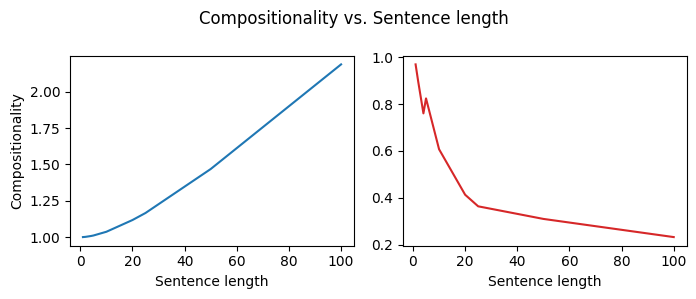

In [3]:
d = 100
compositionalities = []
ks = []
topsims = []
for k in range(1, d + 1):
    if d % k != 0:  # skip non-divisible k
        continue
    data_gen = LookupTableDataGenerator(
        num_words=k, vocab_size=10, z_dim=d, disentanglement=1, noise_ratio=0.01
    )
    w, z = data_gen.sample(1000)
    compositionalities.append(data_gen.compositionality(z, w, per_sample=True))
    ks.append(k)
    topsims.append(topological_similarity(w, z))

fig, axs = plt.subplots(1, 2, figsize=(7, 3))
sns.lineplot(x=ks, y=compositionalities, color=sns.color_palette()[0], ax=axs[0])
sns.lineplot(x=ks, y=topsims, color=sns.color_palette()[3], legend=False, ax=axs[1])
fig.suptitle("Compositionality vs. Sentence length")
axs[0].set_xlabel("Sentence length")
axs[1].set_xlabel("Sentence length")
axs[0].set_ylabel("Compositionality")
fig.tight_layout()
plt.show()

### Varying the dimensionality of the representation

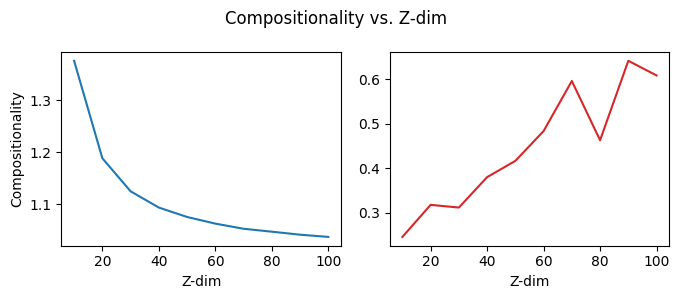

In [2]:
k = 10
compositionalities = []
ds = []
topsims = []
for d in range(k, k * 10 + 1):
    if d % k != 0:  # skip non-divisible k
        continue
    data_gen = LookupTableDataGenerator(
        num_words=k, vocab_size=10, z_dim=d, disentanglement=1, noise_ratio=0.01
    )
    w, z = data_gen.sample(1000)
    compositionalities.append(data_gen.compositionality(z, w, per_sample=True))
    ds.append(d)
    topsims.append(topological_similarity(w, z))

fig, axs = plt.subplots(1, 2, figsize=(7, 3))
sns.lineplot(x=ds, y=compositionalities, color=sns.color_palette()[0], ax=axs[0])
sns.lineplot(x=ds, y=topsims, color=sns.color_palette()[3], legend=False, ax=axs[1])
fig.suptitle("Compositionality vs. Z-dim")
axs[0].set_xlabel("Z-dim")
axs[1].set_xlabel("Z-dim")
axs[0].set_ylabel("Compositionality")
fig.tight_layout()
plt.show()

## Varying the vocabulary size

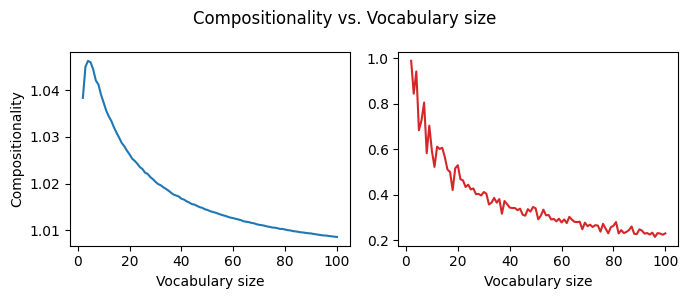

In [3]:
vmax = 100
compositionalities = []
vs = []
topsims = []
for v in range(2, vmax + 1):
    data_gen = LookupTableDataGenerator(
        num_words=10, vocab_size=v, z_dim=100, disentanglement=1, noise_ratio=0.01
    )
    w, z = data_gen.sample(1000)
    compositionalities.append(data_gen.compositionality(z, w, per_sample=True))
    vs.append(v)
    topsims.append(topological_similarity(w, z))

fig, axs = plt.subplots(1, 2, figsize=(7, 3))
sns.lineplot(x=vs, y=compositionalities, color=sns.color_palette()[0], ax=axs[0])
sns.lineplot(x=vs, y=topsims, color=sns.color_palette()[3], legend=False, ax=axs[1])
fig.suptitle("Compositionality vs. Vocabulary size")
axs[0].set_xlabel("Vocabulary size")
axs[1].set_xlabel("Vocabulary size")
axs[0].set_ylabel("Compositionality")
fig.tight_layout()
plt.show()

### Varying the disentanglement

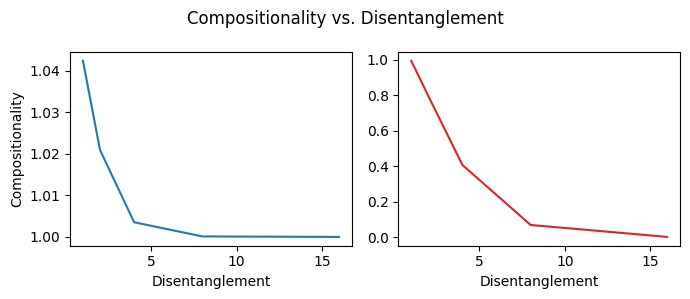

In [4]:
k = 16
z_dim = k * 10
compositionalities = []
ds = []
topsims = []
for d in range(1, k + 1):
    if k % d != 0:
        continue
    data_gen = LookupTableDataGenerator(
        num_words=k, vocab_size=2, z_dim=z_dim, disentanglement=d, noise_ratio=0.01
    )
    w, z = data_gen.sample(1000)
    compositionalities.append(data_gen.compositionality(z, w, per_sample=True))
    ds.append(d)
    topsims.append(topological_similarity(w, z))

fig, axs = plt.subplots(1, 2, figsize=(7, 3))
sns.lineplot(x=ds, y=compositionalities, color=sns.color_palette()[0], ax=axs[0])
sns.lineplot(x=ds, y=topsims, color=sns.color_palette()[3], legend=False, ax=axs[1])
fig.suptitle("Compositionality vs. Disentanglement")
axs[0].set_xlabel("Disentanglement")
axs[1].set_xlabel("Disentanglement")
axs[0].set_ylabel("Compositionality")
fig.tight_layout()
plt.show()

# Hierarchical syntax

### Varying the number of rules

  0%|          | 0/9 [00:00<?, ?it/s]

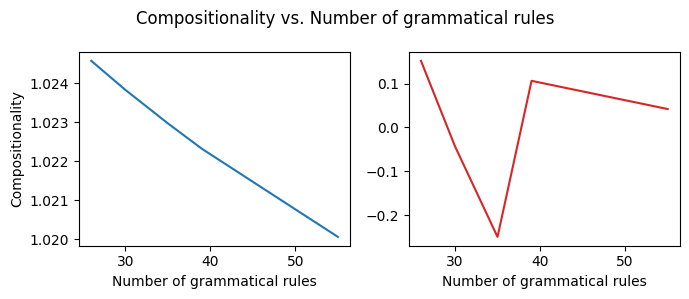

In [2]:
z_dim = 10
num_words = 64
vocab_size = 2048
num_terminal_pos = 5


def gen_grammar(vocab_size, num_terminal_pos, decay_rate):
    vocab_terms = {i: "T_" + str(i % num_terminal_pos + 1) for i in range(vocab_size)}
    grammar = {}
    level = 1
    prev_pos = num_terminal_pos
    next_pos = max(int(decay_rate * num_terminal_pos), 1)
    while prev_pos > 1:
        lead = "T" if level == 1 else f"r{level-1}"
        for i, pair in enumerate(product(range(prev_pos), repeat=2)):
            grammar[(f"{lead}_{pair[0] + 1}", f"{lead}_{pair[1] + 1}")] = (
                f"r{level}_{i % next_pos + 1}"
            )
        level += 1
        prev_pos = next_pos
        next_pos = max(int(decay_rate * next_pos), 1)
    grammar[(f"r{level-1}_1", f"r{level-1}_1")] = f"r{level-1}_1"
    roots = [f"r{level-1}_1"]
    return vocab_terms, grammar, roots


compositionalities = []
num_grammar_rules = []
topsims = []
for decay_rate in tqdm(np.linspace(0.1, 0.9, 9)):
    vocab_terms, grammar, roots = gen_grammar(vocab_size, num_terminal_pos, decay_rate)
    data_gen = SyntacticDataGenerator(
        z_dim=z_dim,
        num_words=num_words,
        vocab_size=vocab_size,
        vocab_terms=vocab_terms,
        grammar=grammar,
        roots=roots,
        noise_ratio=0.01,
    )
    w, z = data_gen.sample(10)
    compositionalities.append(data_gen.compositionality(z, w, per_sample=True))
    num_grammar_rules.append(len(grammar))
    topsims.append(topological_similarity(w, z))

fig, axs = plt.subplots(1, 2, figsize=(7, 3))
sns.lineplot(
    x=num_grammar_rules, y=compositionalities, color=sns.color_palette()[0], ax=axs[0]
)
sns.lineplot(
    x=num_grammar_rules,
    y=topsims,
    color=sns.color_palette()[3],
    legend=False,
    ax=axs[1],
)
fig.suptitle("Compositionality vs. Number of grammatical rules")
axs[0].set_xlabel("Number of grammatical rules")
axs[1].set_xlabel("Number of grammatical rules")
axs[0].set_ylabel("Compositionality")
fig.tight_layout()
plt.show()

### Natural toy grammar

Taken from [here](https://pages.uoregon.edu/tpayne/UEG/UEG-exercises-ch8.pdf) for now

In [11]:
z_dim = 10
num_words = 64
vocab_size = 4
vocab_terms = {
    0: "A",
    1: "A",
    2: "B",
    3: "B",
}
grammar = {
    ("A", "B"): "d",
    ("B", "A"): "d",
    ("B", "B"): "c",
    ("c", "c"): "c",
    ("c", "d"): "d",
    ("d", "c"): "d",
    ("d", "d"): "c",
}
roots = ["c", "d"]
language = {
    "START": ["B"],
    "A": ["B"],
    "B": ["A", "B"],
}

grammar = SyntacticDataGenerator(
    z_dim=z_dim,
    num_words=num_words,
    vocab_size=vocab_size,
    vocab_terms=vocab_terms,
    grammar=grammar,
    roots=roots,
    language=language,
    noise_ratio=0.01,
)